In [1]:
import pandas as pd
import torch
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import numpy as np
import tensorflow as tf
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import RandomSampler, SequentialSampler
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [2]:
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


In [3]:
device = torch.device("cuda")
device

device(type='cuda')

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
trainingData = pd.read_csv('/content/drive/My Drive/Assignment 3 NLP/train.csv', delimiter="\t")
validationData = pd.read_csv('/content/drive/My Drive/Assignment 3 NLP/dev.csv', delimiter="\t")

In [6]:
validationData

,score,setence1,sentence2
0,5.00,A man with a hard hat is dancing.,A man wearing a hard hat is dancing.
1,4.75,A young child is riding a horse.,A child is riding a horse.
2,5.00,A man is feeding a mouse to a snake.,The man is feeding a mouse to the snake.
3,2.40,A woman is playing the guitar.,A man is playing guitar.
4,2.75,A woman is playing the flute.,A man is playing a flute.
...,...,...,...
1465,2.00,Scientists prove there is water on Mars,Has Nasa discovered water on Mars?
1466,0.00,Pranab stresses need to strive for peace by na...,WTO: India regrets action of developed nations
1467,2.00,Volkswagen skids into red in wake of pollution...,"Volkswagen's ""gesture of goodwill"" to diesel o..."
1468,0.00,Obama is right: Africa deserves better leadership,Obama waiting for midterm to name attorney gen...


In [7]:
null_mask = trainingData.isnull().any(axis=1)
trainingData[null_mask]
null_mask = validationData.isnull().any(axis=1)
validationData[null_mask]

,score,setence1,sentence2
764,1.4,The grass family is one of the most widely dis...,NaN
1024,3.8,"She was crying and scared,' said Isa Yasin, th...",NaN


In [8]:
trainingData.isnull().sum().sum()

3

In [9]:
trainingData = trainingData.dropna(subset=['sentence1', 'sentence2', 'score'])
trainingData.reset_index(drop=True, inplace = True)
validationData = validationData.dropna(subset=['setence1', 'sentence2', 'score'])
validationData.reset_index(drop=True, inplace = True)
validationData

,score,setence1,sentence2
0,5.00,A man with a hard hat is dancing.,A man wearing a hard hat is dancing.
1,4.75,A young child is riding a horse.,A child is riding a horse.
2,5.00,A man is feeding a mouse to a snake.,The man is feeding a mouse to the snake.
3,2.40,A woman is playing the guitar.,A man is playing guitar.
4,2.75,A woman is playing the flute.,A man is playing a flute.
...,...,...,...
1463,2.00,Scientists prove there is water on Mars,Has Nasa discovered water on Mars?
1464,0.00,Pranab stresses need to strive for peace by na...,WTO: India regrets action of developed nations
1465,2.00,Volkswagen skids into red in wake of pollution...,"Volkswagen's ""gesture of goodwill"" to diesel o..."
1466,0.00,Obama is right: Africa deserves better leadership,Obama waiting for midterm to name attorney gen...


In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
inputIds = []
attentionMask = []
max_length= 64

for rowNo in range(len(trainingData)):
  sen1 = trainingData.iloc[rowNo]['sentence1']
  sen2 = trainingData.iloc[rowNo]['sentence2']
  print("Sen 1: {}  Sen 2: {}".format(sen1, sen2))
  encodedDict = tokenizer.encode_plus(sen1, sen2, add_special_tokens=True, max_length= 64, padding = 'max_length', truncation = True)
  inputIds.append(encodedDict['input_ids'])
  attentionMask.append(encodedDict['attention_mask'])
inputIds

Sen 1: A plane is taking off.  Sen 2: An air plane is taking off.
Sen 1: A man is playing a large flute.  Sen 2: A man is playing a flute.
Sen 1: A man is spreading shreded cheese on a pizza.  Sen 2: A man is spreading shredded cheese on an uncooked pizza.
Sen 1: Three men are playing chess.  Sen 2: Two men are playing chess.
Sen 1: A man is playing the cello.  Sen 2: A man seated is playing the cello.
Sen 1: Some men are fighting.  Sen 2: Two men are fighting.
Sen 1: A man is smoking.  Sen 2: A man is skating.
Sen 1: The man is playing the piano.  Sen 2: The man is playing the guitar.
Sen 1: A man is playing on a guitar and singing.  Sen 2: A woman is playing an acoustic guitar and singing.
Sen 1: A person is throwing a cat on to the ceiling.  Sen 2: A person throws a cat on the ceiling.
Sen 1: The man hit the other man with a stick.  Sen 2: The man spanked the other man with a stick.
Sen 1: A woman picks up and holds a baby kangaroo.  Sen 2: A woman picks up and holds a baby kangaroo

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Sen 1: A baseball player throws the ball.  Sen 2: The basketball player holds the ball.
Sen 1: A man is swinging on a rope over water.  Sen 2: A man in a maroon bathing suit swings on a rope on a lake.
Sen 1: A young girl dressed in a Minnie mouse outfit and an older woman walking down the sidewalk.  Sen 2: a man wearing a white suit holding a newspaper walking through the streets.
Sen 1: How about some testimonies from real health experts?  Sen 2: Also, who's to say there aren't testimonies from "real" health experts on there?
Sen 1: Then the captain was gone.	Then the captain came back.
main-forum	deft-forum	2014	0002	3.8	The problem is simpler than that.	The problem is simple.
main-forum	deft-forum	2014	0003	1	NEGATIVE RECONNAISSANCE REQUIREMENTS.	PACIFIC REQUIREMENTS .
main-forum	deft-forum	2014	0004	0.4	So, I am dropping, for now, asking you the question:  Where ' s the Marx " ?  Sen 2: I am moving on to ask you the question: " Where ' s the beef " ?
Sen 1: go figure You're asking

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Sen 1: We are all vessels filled with many wonders.  Sen 2: Jingle Bell Rock by Bobby Helm We are all vessels filled with many wonders.
Sen 1: the problem isn't who has money.  Sen 2: the problem is who doesn't have money.
Sen 1: Sadly Ford did accept taxpayer money.  Sen 2: Ford didn't accept taxpayer money to save the company.
Sen 1: The Muslims would say the same thing about the Qur'an.  Sen 2: The Hindus would say the same thing about the Bhagavad Ghita.
Sen 1: Your confusion doesn't make me a liar.  Sen 2: Then your confusion doesn't make me a liar either.
Sen 1: When Christians are extreme its just simply religion.  Sen 2: When Muslims are extreme it's terrorism.
Sen 1: Some believe the 'right' is most important.  Sen 2: Some believe not slaughtering the unborn is most important.
Sen 1: Evolution is not an opinion, not a belief.  Sen 2: Atomic theory is not an opinion, not a belief.
Sen 1: I am not the one claiming the right to decide over another woman's body.  Sen 2: You want o

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Sen 1: After protesters rushed the stage and twice cut power to the microphone, Hedges drew the speech to an early close.  Sen 2: After protesters rushed the stage and twice cut power to the microphone, Hedges cut his speech short.
Sen 1: A passer-by found Ben hiding along a dirt road in Spanish Fork Canyon about 7 p.m., with his hands still taped together but his feet free.  Sen 2: A passer-by found the boy hiding along a dirt road in Spanish Fork Canyon about 7 p.m. Thursday, with his feet free but his hands still taped.
Sen 1: Doctors say one or both boys may die, and that some brain damage is possible if they survive.  Sen 2: Doctors said that one or both of the boys may die and that if they survive, some brain damage is possible.
Sen 1: Also missing is Al Larsen, 31, of Fort Worth, Texas, who was in another vehicle swept off the turnpike.  Sen 2: The other victim recovered Tuesday morning was Al Larsen, 31, of Fort Worth, Texas.
Sen 1: British-based GlaxoSmithKline Plc said earlie

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Sen 1: Chief merchandising officers oversee the buying and development of merchandise, deciding the merchandising direction of the company, or basically what it should stand for.  Sen 2: He or she decides the merchandising direction of the company, or basically what it should stand for.
Sen 1: The Rev. Christopher J. Coyne, spokesman for the archdiocese, wouldn't comment Friday.  Sen 2: The Rev. Christopher Coyne, spokesman for the archdiocese, did not immediately return several calls seeking comment.
Sen 1: Several relatives of Australian victims of the attack were in court to witness the proceedings, but few Balinese attended the trial.  Sen 2: Several relatives of Australian victims of the attack sat in the front row of the court, but few Balinese attended the trial.
Sen 1: On July 10, a team of 32 Singaporean police officers was sent to Baghdad.  Sen 2: In July 32 Singaporean police officers were sent to Baghdad to help train Iraqi police forces and returned home last month.
Sen 1:

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Sen 1: They made a similar discovery in Houston on another aircraft, Dallas-based Southwest said in a statement.  Sen 2: The airline said a similar discovery was made on the plane in Houston.
Sen 1: Rosenthal declined comment on the Garrett situation Tuesday but said in a statement: "We had a big contract negotiation.  Sen 2: The show's creator and executive producer, Phil Rosenthal, quipped in a statement: "We had a big contract negotiation.
Sen 1: With the power back on, state workers headed back to their jobs Friday morning.  Sen 2: Pataki said if power was restored, state workers would be back on the job Friday morning.
Sen 1: The Nasdaq fell about 1.3% for the month, snapping a seven-month winning streak.  Sen 2: The Nasdaq is down roughly 0.4 percent for the month, on track to snap a 7-month streak of gains.
Sen 1: The report was found Oct. 23, tucked inside an old three-ring binder not related to the investigation.  Sen 2: The report was found last week tucked inside a training 

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai


Sen 1: Chapman was not immediately arrested and is expected to appear for arraignment July 3.  Sen 2: Mr. Chapman, who hasn't been arrested, is expected to appear for arraignment next Thursday, prosecutors said.
Sen 1: President Bush raised a record-breaking $49.5 million for his re-election campaign over the last three months, with contributions from 262,000 Americans, the president's campaign chairman said Tuesday.  Sen 2: President Bush has raised $83.9 million since beginning his re-election campaign in May, and has $70 million of that left to spend, his campaign said Tuesday.
Sen 1: Authorities in Ohio, Indiana and Michigan have searched for the bodies.  Sen 2: So far, authorities also have searched areas in Pennsylvania, Ohio, Indiana, and Michigan.
Sen 1: He said European governments "have blocked all new bio-crops because of unfounded, unscientific fears.  Sen 2: They have blocked all new bio-crops because of unfounded, unscientific fears, Bush said.
Sen 1: One question was wh

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai


Sen 1: October heating oil futures settled .85 cent lower at 69.89 cents a gallon.  Sen 2: October heating oil ended down 0.41 cent to 70.74 cents a gallon.
Sen 1: Mr Levine confirmed that Ms Cohen Alon had tried to sell the story during the World Cup.  Sen 2: Ms Cohen Alon's lawyer, Donald Levine, confirmed she tried to sell the story in February.
Sen 1: Mr. Bankhead said the crime scenes indicated that the killer was "very methodical."  Sen 2: GBI spokesman John Bankhead said the murder scenes showed that the killer was very methodical.
Sen 1: This moves us a lot closer to saying that the foam can do this kind of damage, said Hubbard, a member of the Columbia Accident Investigation Board.  Sen 2: I think this moves us a lot closer toward saying that foam can do this kind of damage, Hubbard said.
Sen 1: We had nothing to do with @Stake's internal personnel decision, Microsoft spokesman Sean Sundwell said.  Sen 2: Microsoft had absolutely nothing to do with AtStake's internal personne

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Sen 1: Ms. Cripps-Prawak left last Friday, two days after the department introduced a plan to distribute medical marijuana through doctors' offices.  Sen 2: The director of the Office of Medical Access, Cindy Cripps-Prawak, left her job after the department introduced a plan to distribute marijuana through doctors' offices.
Sen 1: During 2001 and 2002, Morgenthau said, wire transfers from just four of Beacon Hill's 40 accounts totaled more than $3.2 billion.  Sen 2: Wire transfers from four of the 40 accounts open at Beacon Hill totaled more than $3.2 billion from 2001 to 2002, Morgenthau said.
Sen 1: Last year, he made an unsuccessful bid for the Democratic nomination for governor.  Sen 2: He ran last year for the Democratic nomination for Texas governor, but lost the primary to multimillionaire Tony Sanchez.
Sen 1: The nation's largest retailer has told its 100 top suppliers they have to start using electronic tags on all pallets of goods by Jan. 25, 2005.  Sen 2: Wal-Mart has told i

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Sen 1: Bremer said one initiative is to launch a $70 million nationwide program in the next two weeks to clean up neighborhoods and build community projects.  Sen 2: Bremer said he would launch a $70-million program in the next two weeks to clean up neighborhoods across Iraq and build community projects, but gave no details.
Sen 1: The Nasdaq composite index added 30.46 points, or 2 percent, to 1,520.15.  Sen 2: The Nasdaq had a weekly gain of 17.27, or 1.2 percent, closing at 1,520.15 after gaining 30.46 yesterday.
Sen 1: The British Foreign Office said Monday that coalition authorities in Iraq were pleased that the men were freed.  Sen 2: The British Foreign Office said it had mediated the two men's release.
Sen 1: Wal-Mart estimates more than 100 million Americans visit their stores every week.  Sen 2: Each week 138 million shoppers visit Wal-Mart's 4,750 stores.
Sen 1: Added Mr. Prodi: "Maybe, but the old age helps us to understand our strengths and our weakness."  Sen 2: Maybe, bu

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Sen 1: Griffith, a Mount Airy native, now lives on the North Carolina coast in Manteo.  Sen 2: Griffith, 77, grew up in Mount Airy and now lives in Manteo.
Sen 1: The Conference Board reported its U.S. Consumer Confidence Index slipped to 83.5 in June from 83.6 in May.  Sen 2: The consumer-confidence index came in at 83.5 in June, down slightly from a revised 83.6 in May, the Conference Board said.
Sen 1: I notice a mood change in their priorities, one politician said.  Sen 2: I notice a mood change in their priorities, said one Iraqi politician after meeting with Mr. Bremer.
Sen 1: Heather, 35, who lost a leg in a road accident, is thought to have steel plates fitted in her hips, which would make natural childbirth impossible.  Sen 2: Former model Lady McCartney lost a leg in a road accident in 1993 and is understood to have steel plates fitted in her hips which would make natural childbirth difficult.
Sen 1: The network is also dropping its Friday night "Dateline" edition.  Sen 2: Th

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Sen 1: According to law enforcement officials, the person arrested was a known sophisticated hacker.  Sen 2: According to law enforcement officials, the individual decrypted passwords on the server.
Sen 1: Excluding litigation charges, RIM's loss narrowed even further to 1 cent a share.  Sen 2: Excluding patent litigation, RIM's loss for the quarter was $700,000, or 1 cent per share.
Sen 1: The broad Standard & Poor's 500 Index .SPX gained 19.72 points, or 1.98 percent, to 1,015.69.  Sen 2: The Dow Jones industrial average .DJI jumped 2.09 percent, while the Standard & Poor's 500 Index .SPX leapt 2.23 percent.
Sen 1: It will also help reform the Royal Solomon Islands Police, strengthen the courts and prisons system and protect key institutions such as the Finance Ministry from intimidation.  Sen 2: The intervention force will confiscate weapons, reform the police, strengthen the courts and prison system and protect key institutions such as the Finance Ministry.
Sen 1: Mr Alibek said: "

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai


Sen 1: Yee is a 1990 graduate of the U.S. Military Academy at West Point, New York.  Sen 2: Yee grew up in the United States and graduated from the U.S. Military Academy at West Point.
Sen 1: PNC regrets its involvement in the deals, Chairman and Chief Executive Officer James Rohr said in a statement.  Sen 2: James Rohr, chairman and chief executive officer, said PNC regretted the incident.
Sen 1: CCAG supported Bill Curry, Rowland's opponent in the 2002 gubernatorial election.  Sen 2: Mr. Swan's group supported the governor's Democratic opponent, Bill Curry, in the 2002 election.
Sen 1: They later fell out and have backed a series of rival Congolese militias in recent years.  Sen 2: The two invading countries later fell out, and have since backed rival factions.
Sen 1: Another said its members would continue to call the more than 50 million phone numbers on the Federal Trade Commission's list.  Sen 2: Meantime, the Direct Marketing Association said its members should not call the nea

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai


Sen 1: Shares of McDonald's rose $1.83, or 8.3 percent, to close at the day's high of $23.89.  Sen 2: McDonald's shares rose $1.83 to close Friday at $23.89 on the New York Stock Exchange.
Sen 1: He said the FDA was hoping Congress and the courts would bring clarity to the situation and some financial relief to consumers.  Sen 2: He said FDA hopes Congress and the courts will bring clarity to the situation and some financial relief to consumers — perhaps before the 2004 elections.
Sen 1: Ernst & Young admitted no wrongdoing with the settlement.  Sen 2: Ernst & Young spokesman Kenneth Kerrigan said the firm admits no wrongdoing.
Sen 1: The witness, a 27-year-old Kosovan parking attendant with criminal convictions for dishonesty, was paid 10,000 by the News of the World.  Sen 2: The witness was a 27-year-old Kosovan parking attendant, who was paid by the News of the World, the court heard.
Sen 1: The differences between Grassley and Thomas on energy and Medicare have become so pointed t

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Sen 1: TVT Records sought $360 million in punitive damages and $30 million in compensatory damages, officials said.  Sen 2: The damages included $24 million in compensatory damages and $52 million in punitive damages for IDJ.
Sen 1: The two Democrats on the five-member FCC panel held a news conference to sway opinion against Powell.  Sen 2: The two Democrats on the five-member FCC held a news conference to sway opinion against Powell and the panel's two other Republicans.
Sen 1: Unit volumes also set a record as notebooks accounted for more than 40 percent of sales.  Sen 2: In May 2002, LCDs accounted for only 22 percent of monitor sales.
Sen 1: Besides battling its sales slump, Siebel also has been sparring with some investors upset about huge stock option windfalls company managers have pocketed.  Sen 2: Besides a sales slump, Siebel is sparring with some shareholders over management stock option windfalls.
Sen 1: Stanford (51-17) and Rice (57-12) will play for the national champions

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Sen 1: human rights violations in myanmar include summary executions, torture and the recruitment of child soldiers.   Sen 2: these human rights violations include summary executions, torture and the recruitment of child
Sen 1: general nikolai n. urakov stated by telephone that the state scientific center of applied microbiology has quite reliable systems of protection in case of emergency.   Sen 2: general nikolai n. urakov is the longtime director of the the state scientific center of applied microbiology.
Sen 1: alstom is in competition with japanese and german countries for the contract.   Sen 2: alstom is competing against japanese company shinkansen and german company ice for the contract.
Sen 1: the legislation is the most recent effort by japan to ascribe more freedom to its tightly controlled military and would overturn a ban on the military use of space.   Sen 2: the legislation is the most recent effort by japan to ascribe more freedom to the tightly controlled military tech

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai


Sen 1: the new law attempts to remove any legal obstacles to building more advanced spy satellites and to help innovation in japans's space industry.   Sen 2: the purpose of the new law is to remove any legal obstacles to building more advanced spy satellites and to encourage innovation in japans's space industry.
Sen 1: zhang stated-- china opposes restricting the peaceful use of nuclear energy by non-nuclear-weapon states on the basis of non-proliferation because the peaceful use of nuclear energy is a crucial objective of the npt.   Sen 2: zhang yan stated that china opposes using non-proliferation as a pretext for restricting and depriving non-nuclear-weapon states of the right to peaceful use of nuclear energy.
Sen 1: non-proliferation expert at the international institute for strategic studies mark fitzpatrick stated that the iaea report -- had an unusually strong tenor.   Sen 2: senior fellow at the international institute for strategic studies mark fitzpatrick stated that-- th

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai


Sen 1: an institute for public policy research report said there are 27 weak states that pose a threat to britain's national security as the states could provide bases for terrorists.  Sen 2: the report said there are 27 weak states that pose a threat to britain's national security as the states could provide bases for terrorists.
Sen 1: the iranian government denied the accusation and insists the nuclear program is for peaceful purposes only.   Sen 2: iran insists that its nuclear program is for peaceful purposes
Sen 1: the proliferation security initiative calls for stopping and searching ships suspected of carrying weapons of mass destruction.   Sen 2: members of the proliferation security initiative are considering ways of intercepting ships or aircraft suspected of carrying weapons of mass destruction.
Sen 1: the international community should modernize and seek a fair, reasonable and effective way to enhance the nuclear non-proliferation regime through extensive consultations.  

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Sen 1: a siemens spokesman in germany stated to the agence france-presse that siemens was confident about the outcome of the talks to sell the plutonium-processing facility.   Sen 2: a siemens spokesman in germany refrained from commenting on the political aspect of the sale of the plutonium-processing facility.
Sen 1: the cyber attack occurred after the french president sarkozy's meeting with the dalai lama angered the chinese government.   Sen 2: the cyber attack occurred after french president nicolas sarkozy's meeting with exiled tibetan spiritual leader the dalai lama.
Sen 1: the south african government imposed a ban that prohibits the recruitment of people inside or outside of south africa for mercenary or foreign military assistance.   Sen 2: south africa's foreign ministry stated that south africa's foreign military assistance act prohibits the recruitment of people inside or outside of south africa for mercenary or foreign military assistance.
Sen 1: ukraine almost has all of

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Sen 1: the international atomic energy association stated that jordan has agreed to the additional measures.   Sen 2: international atomic energy association is the united nations watchdog.
Sen 1: there is much concern over the drug.   Sen 2: there is much work to be done.
Sen 1: the amnesty international report suggested that-- belgium begin immediate talks with india to prevent future sales of the alh, components or military technology to myanmar.   Sen 2: the report urged belgium to begin immediate talks with india in order to prevent future weapons sale to myanmar.
Sen 1: capital offenses in iran include murder, rape, armed robbery, apostasy, blasphemy, serious drug trafficking, repeated sodomy, adultery, prostitution, treason and espionage.   Sen 2: capital offenses in iran include murder, rape, armed robbery, serious drug trafficking and adultery.
Sen 1: saudi arabia is an absolute monarchy that has taken steps towards reform.   Sen 2: saudi arabia is an absolute monarchy and has

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



Sen 1: Five convicted in Kosovo organ trafficking case  Sen 2: Kosovo: 3 get jail time in organ trafficking case
Sen 1: Hrithik Roshan, wife Sussanne part ways  Sen 2: Hrithik Roshan, Sussanne to divorce
Sen 1: Gunman Among 7 Dead After Florida Apartment Shooting  Sen 2: Gunman among 7 dead after Fla. apartment shootout
Sen 1: Obama lauds progress on gay rights in inaugural address  Sen 2: Thousands protest gay marriage in France
Sen 1: Wave of bombings kills 15 in Iraq  Sen 2: Car bombs kill at least 49 in Iraq
Sen 1: In shock move, Obama puts Syria strike on hold  Sen 2: Obama puts Syria strike on hold
Sen 1: Israel strikes Syria as tensions rise on weapons  Sen 2: Air strikes wound civilians in Syria's Deraa
Sen 1: Gunmen kill nine people in northwest Pakistan  Sen 2: Militants kill 6 soldiers in northwest Pakistan
Sen 1: The San Francisco plane crash at a glance  Sen 2: Two dead, 181 hurt in San Francisco air crash
Sen 1: 8 arrested after deadly Bangladesh building collapse  Sen 2

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Sen 1: Pak missions in UAE gear up for elections  Sen 2: Islamist parties in Egypt unite for elections
Sen 1: Bangladesh building disaster death toll passes 500  Sen 2: Bangladesh building collapse: death toll climbs to 580
Sen 1: Algeria hostage crisis ends; death toll unclear  Sen 2: Algeria hostage crisis ends in bloodbath
Sen 1: Egypt ministry again urges end to pro-Morsi protests  Sen 2: Egypt: Child killed in Cairo clashes after pro-Morsi protest
Sen 1: South Africa's Mandela taken to hospital  Sen 2: South Africa: Mandela remains in hospital
Sen 1: China yuan strengthens to 6.2689 against USD  Sen 2: China yuan strengthens to new high against USD
Sen 1: Police question man in deadly LA boardwalk crash  Sen 2: Police arrest suspect in deadly LA driving attack
Sen 1: Turkish riot police tear gas Taksim Square protest  Sen 2: Turkish riot police enter Taksim Square
Sen 1: Chicago Shooting Shows Gap in Stepped-up Policing  Sen 2: Chicago shooting shows gap in stepped-up policing
Sen

[[101,
  1037,
  4946,
  2003,
  2635,
  2125,
  1012,
  102,
  2019,
  2250,
  4946,
  2003,
  2635,
  2125,
  1012,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [101,
  1037,
  2158,
  2003,
  2652,
  1037,
  2312,
  8928,
  1012,
  102,
  1037,
  2158,
  2003,
  2652,
  1037,
  8928,
  1012,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [101,
  1037,
  2158,
  2003,
  9359,
  14021,
  5596,
  2098,
  8808,
  2006,
  1037,
  10733,
  1012,
  102,
  1037,
  2158,
  2003,
  9359,
  29022,
  8808,
  2006,
  2019,
  4895,
  3597,
  23461,
  10733,
  1012,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

In [12]:
inputIdsValdiation = []
attentionMaskValidation = []
max_length= 64

for rowNo in range(len(validationData)):
  sen1 = validationData.iloc[rowNo]['setence1']
  sen2 = validationData.iloc[rowNo]['sentence2']
  print("Sen 1: {}  Sen 2: {}".format(sen1, sen2))
  encodedDict = tokenizer.encode_plus(sen1, sen2, add_special_tokens=True, max_length= 64, padding = 'max_length', truncation = True)
  inputIdsValdiation.append(encodedDict['input_ids'])
  attentionMaskValidation.append(encodedDict['attention_mask'])
inputIdsValdiation

Sen 1: A man with a hard hat is dancing.  Sen 2: A man wearing a hard hat is dancing.
Sen 1: A young child is riding a horse.  Sen 2: A child is riding a horse.
Sen 1: A man is feeding a mouse to a snake.  Sen 2: The man is feeding a mouse to the snake.
Sen 1: A woman is playing the guitar.  Sen 2: A man is playing guitar.
Sen 1: A woman is playing the flute.  Sen 2: A man is playing a flute.
Sen 1: A woman is cutting an onion.  Sen 2: A man is cutting onions.
Sen 1: A man is erasing a chalk board.  Sen 2: The man is erasing the chalk board.
Sen 1: A woman is carrying a boy.  Sen 2: A woman is carrying her baby.
Sen 1: Three men are playing guitars.  Sen 2: Three men are on stage playing guitars.
Sen 1: A woman peels a potato.  Sen 2: A woman is peeling a potato.
Sen 1: People are playing cricket.  Sen 2: Men are playing cricket.
Sen 1: A man is playing a guitar.  Sen 2: A man is playing a flute.
Sen 1: The cougar is chasing the bear.  Sen 2: A cougar is chasing a bear.
Sen 1: The man 

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Sen 1: A young blonde girl wearing a smile and a bicycle helmet.  Sen 2: A young girl wearing a bike helmet with a bicycle in the background.
Sen 1: Two brown horses standing in grassy field.  Sen 2: Brown horse standing in middle of grassy field.
Sen 1: Boy lying on couch with small white dog.  Sen 2: A small boy laying on a sofa with a dog.
Sen 1: A woman is laying down on the floor and holding a baby up above her.  Sen 2: A man is laying on the floor holding a baby up above him.
Sen 1: A grey house with a red door.  Sen 2: House with a red door.
Sen 1: A woman with a white horse.  Sen 2: A woman leading a white horse.
Sen 1: Depressed woman sitting on couch.  Sen 2: Older woman holding newborn baby.
Sen 1: An elderly woman catches a ride on the back of the bicycle.  Sen 2: The boats are on the water located in front of the mountain.
Sen 1: The brown and white cows are eating in the trough.  Sen 2: Brown and white cows are eating from a trough.
Sen 1: A young woman with outstretched 

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Sen 1: In general there are a number of different distinct workflows that lead to a poster.  Sen 2: For completeness, Apple's Pages has quite a few nice poster layouts.
Sen 1: It is perfectly okay to ask for the figure knowing well that the other person may not give.  Sen 2: You can always ask, then it is the choice of the author to accept or not.
Sen 1: The academic year does start around September in the USA and I think most European countries.  Sen 2: I would not accelerate things, to avoid getting worse grades that you want.
Sen 1: I will advise exactly the contrary of what bravo just said in another answer : go for A !  Sen 2: You could defer admission, but it's a little unusual to defer for a year.
Sen 1: Edit, again: The question seems to have changed, yet again.  Sen 2: I can think of three reasons why a faculty member might reveal how a student performed on a qualifying examination.
Sen 1: I agree with Seteropere completely, "Network Science" is a very broad subject.  Sen 2: I

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Sen 1: Well for one a being could have a non-physical existance and yet not even be in your mind.  Sen 2: The difference is huge, as not all non-physical things exist in minds.
Sen 1: People who are good at the philosophy of mathematics are mathematicians and not philosophers.  Sen 2: My motivation is that I like to look at things from their roots and go up.
Sen 1: The difference between "necessary" and "sufficient" is the direction of the logical arrow.  Sen 2: sufficient is an upper bound, necessary is a lower bound.
Sen 1: I have no idea why it is voted up, but Rex Kerr's answer begs the question.  Sen 2: It's a tautology, but the mapping between logic and the English-language description is wrong.
Sen 1: It's true that, under one understanding of "accessibility" and "determining", your accessibility relation is determined by your axioms.  Sen 2: Accessibility is determined by the axioms of the modal logic you're working within.
Sen 1: I once met a physicists who held the strong AI 

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Sen 1: The budget analysis comes as negotiations between the City Council and the Bloomberg administration heat up.  Sen 2: Budget negotiations between the mayor and the City Council are entering high gear.
Sen 1: Also at increased risk are those whose immune systems suppressed by medications or by diseases such as cancer, diabetes and AIDS.  Sen 2: Also at increased risk are those with suppressed immune systems due to illness or medicines.
Sen 1: Shares of Coke closed New York Stock Exchange trading Thursday at $44.01.  Sen 2: In morning trading on the New York Stock Exchange, Coca-Cola shares were down 34 cents at $43.67.
Sen 1: I feel that people that are sending these messages are infringing on my rights and everyone else's rights to use their computers, said McKechnie.  Sen 2: The people who are sending these messages are infringing on my rights and everyone else's rights to use your computer," McKechnie said.
Sen 1: Generally unwanted - and often pornographic or with fraudulent i

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Sen 1: The veteran Malyasian diplomat met Suu Kyi Wednesday at the lakeside home in Yangon where she is under house arrest.  Sen 2: Razali Ismail met for 90 minutes with Suu Kyi, a 1991 winner of the Nobel Peace Prize, at her lakeside home, where she is under house arrest.
Sen 1: At first blush, then, the distinction drawn by the creators of the do-not-call registry would seem to draw the line in precisely the right place.  Sen 2: At first blush, then, the creators of the registry would seem to have drawn the line between exempted and banned calls in the right place.
Sen 1: Ukrainian President Leonid Kuchma today cut short a visit to Latin America as a bitter border wrangle between Ukraine and Russia deteriorates further.  Sen 2: The dispute has led Ukrainian president Leonid Kuchma to cut short a state visit to Latin America.
Sen 1: Chechen officials working for the Moscow-backed government are a frequent target for rebels and tension is running high ahead of next Sunday's presidentia

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai


Sen 1: Tail wagging, Abbey trotted on stage with Conway before a crowd of more than 10,000 attendees at PeopleSoft's annual customer conference at the Anaheim Convention Center.  Sen 2: On Monday, Abbey trotted on stage, tail wagging, with Conway before a crowd of 10,000 attendees at PeopleSoft's annual customer conference.
Sen 1: At midnight on Wednesday, 68 percent of voters said "no" to the tax, with 97 percent of the votes counted.  Sen 2: With 97 percent of precincts counted tonight, 68 percent of voters opposed the tax.
Sen 1: Graham is expected to be nominated and elected to a second one-year term today and will deliver the presidential address.  Sen 2: Later Tuesday, Graham was expected to be re-elected for a second one-year term.
Sen 1: These changes may affect a large number of existing Web pages, the statement continued.  Sen 2: Still, changes to IE "may affect a large number of existing Web pages," according to the W3C's notice.
Sen 1: Barbini said the union may reach a co

[[101,
  1037,
  2158,
  2007,
  1037,
  2524,
  6045,
  2003,
  5613,
  1012,
  102,
  1037,
  2158,
  4147,
  1037,
  2524,
  6045,
  2003,
  5613,
  1012,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [101,
  1037,
  2402,
  2775,
  2003,
  5559,
  1037,
  3586,
  1012,
  102,
  1037,
  2775,
  2003,
  5559,
  1037,
  3586,
  1012,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [101,
  1037,
  2158,
  2003,
  8521,
  1037,
  8000,
  2000,
  1037,
  7488,
  1012,
  102,
  1996,
  2158,
  2003,
  8521,
  1037,
  8000,
  2000,
  1996,
  7488,
  1012,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

In [13]:
trainInputs = torch.tensor(inputIds)
trainLabels = torch.tensor(trainingData['score'].astype(float))
trainMask = torch.tensor(attentionMask)

In [14]:
valInputs = torch.tensor(inputIdsValdiation)
valLabels = torch.tensor(validationData['score'].astype(float))
valMask = torch.tensor(attentionMaskValidation)

In [15]:
batch_size = 32

train_data = TensorDataset(trainInputs, trainMask, trainLabels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [16]:
batch_size = 32

val_data = TensorDataset(valInputs, valMask, valLabels)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [17]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 1, output_attentions = False, output_hidden_states = False, )
model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [18]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [19]:
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)
scheduler

In [20]:
lossForEpoch = []
for epoch_i in range(0, epochs):
    epochLoss = 0
    model.train()
    for setSize, batch in enumerate(train_dataloader):
        batchInput = batch[0].to(device).to(torch.int64)
        batchAttentionMask = batch[1].to(device).float()
        batchLabels = batch[2].to(device).float()
        model.zero_grad()
        outputs = model(batchInput, token_type_ids=None, attention_mask=batchAttentionMask, labels=batchLabels)
        loss = outputs[0]
        epochLoss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = epochLoss / len(train_dataloader)
    lossForEpoch.append(avg_train_loss)
lossForEpoch

[1.4171419901221824,
 0.5458285140092146,
 0.3920584419253152,
 0.3036084833591344]

In [23]:
model.eval()
yPred , yTrue = [], []
for batch in val_dataloader:
  batch = tuple(t.to(device) for t in batch)
  batchInputs, batchAttentionMask, batchLabels = batch
  with torch.no_grad():
      outputs = model(batchInputs, token_type_ids=None, attention_mask=batchAttentionMask)
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = batchLabels.to('cpu').numpy()
  yPred.append(logits)
  yTrue.append(label_ids)

In [24]:
yPredList = []
for batchOutput in yPred:
  for ele in batchOutput:
    yPredList.append(ele[0])
len(yPredList)

1468

In [25]:
yTrueList = []
for batchOutput in yTrue:
  for ele in batchOutput:
    yTrueList.append(ele)
len(yTrueList)

1468

In [26]:
pearsonr(yTrueList, yPredList)

PearsonRResult(statistic=0.8643919616491242, pvalue=0.0)

In [27]:
checkpoint = {
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}

checkpoint_path = '/content/drive/My Drive/Assignment 3 NLP/Task1 Part A checkpoint.pth'

torch.save(checkpoint, checkpoint_path)

In [28]:
epochNo = list(range(1,epochs+1))

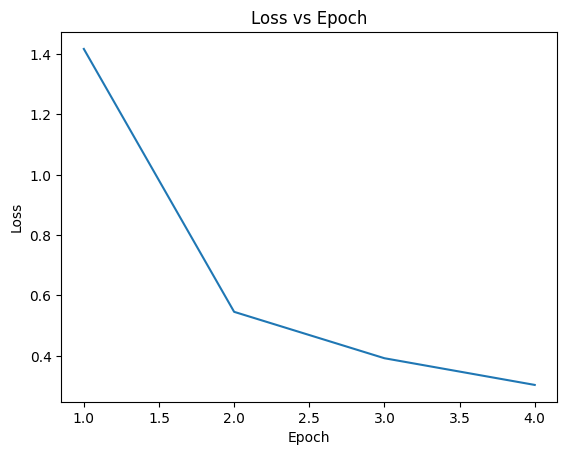

In [29]:
plt.plot(epochNo, lossForEpoch)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.show()

In [30]:
plt.savefig('/content/drive/My Drive/Assignment 3 NLP//Loss vs Epoch.png Task 1 Part A.png')

<Figure size 640x480 with 0 Axes>